<a href="https://colab.research.google.com/github/2series/100_Days_of_ML_Code/blob/master/Simulating_Arrival_Times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you, like me, frequently commute via public transit, you may be familiar with the following situation:

> You arrive at the bus stop, ready to catch your bus: a line that advertises arrivals every 10 minutes. You glance at your watch and note the time... and when the bus finally comes 11 minutes later, you wonder why you always seem to be so unlucky.

Naïvely, you might expect that if buses are coming every 10 minutes and you arrive at a random time, your average wait would be something like 5 minutes. In reality, though, buses do not arrive exactly on schedule, and so you might wait longer. It turns out that under some reasonable assumptions, you can reach a startling conclusion:

**When waiting for a bus that comes on average every 10 minutes, your average waiting time will be 10 minutes.**

*This is what is sometimes known as the waiting time paradox.*

I've encountered this idea before, and always wondered whether it is actually true... how well do those "reasonable assumptions" match reality? This post will explore the waiting time paradox from the standpoint of both **simulation and probabilistic arguments,** and then take a look at some real bus arrival time dataset from the city of Seattle to (hopefully) settle the paradox once and for all.

## The Inspection Paradox
If buses arrive exactly every ten minutes, it's true that your average wait time will be half that interval: 5 minutes. Qualitatively speaking, it's easy to convince yourself that adding some variation to those arrivals will make the average wait time somewhat longer, as we'll see here.

The waiting time paradox turns out to be a particular instance of a more general phenomenon, the inspection paradox, which is discussed at length in this enlightening post by Allen Downey: The Inspection Paradox Is Everywhere.

**Briefly, the inspection paradox arises whenever the probability of observing a quantity is related to the quantity being observed.** Allen gives one example of surveying university students about the average size of their classes. Though the school may truthfully advertise an average of 30 students per class, the average class size as experienced by students can be (and generally will be) much larger. The reason is that there are (of course) more students in the larger classes, and so you oversample large classes when computing the average experience of students.

In the case of a nominally 10-minute bus line, sometimes the span between arrivals will be longer than 10 minutes, and sometimes shorter and if you arrive at a random time, you have more opportunities to encounter a longer interval than to encounter a shorter interval. And so it makes sense that the average span of time experienced by riders will be longer than the average span of time between buses, because the longer spans are over-sampled.

But the waiting time paradox makes a stronger claim than this: when the average span between arrivals is N minutes, the average span experienced by riders is 2N minutes. Could this possibly be true?

## Simulating Wait Times
To convince ourselves that the waiting time paradox is making a reasonable claim, let's start by simulating a stream of buses that arrive at an average of 10 minutes. For the sake of numerical accuracy, we will simulate a large number of bus arrivals: one million buses (or approximately 19 years of round-the-clock 10-minute headways):

In [0]:
# loading libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

In [0]:
# number of buses
N = 1_000_000
# average minutes btw arrivals 
tau = 10

# universal random seed
rand = np.random.RandomState(42)
bus_arrival_times = N * tau * np.sort(rand.rand(N))

Just to confirm we've done things correctly, let's check that the mean interval is close to τ=10:

In [0]:
intervals = np.diff(bus_arrival_times)
intervals.mean()

9.99998796015184

With these bus arrivals simulated, we can now simulate the arrival of a large number of passengers to the bus stop during this span, and compute the wait time that each of them experiences. Let's encapsulate this in a function for later use:

In [0]:
def simulate_wait_times(arrival_times,
                        rseed=8675309,
                        n_passengers=1_000_000):
  rand = np.random.RandomState(rseed)

  arrival_times = np.asarray(arrival_times)
  passenger_times = arrival_times.max() * rand.rand(n_passengers)


  i = np.searchsorted(arrival_times, passenger_times, side='right')

  return arrival_times[i] - passenger_times

We can then simulate some wait times and compute the average:

In [0]:
wait_times = simulate_wait_times(bus_arrival_times)
wait_times.mean()

10.001584206227317

The average wait time is also close to 10 minutes, just as the waiting time paradox predicted.

# Digging Deeper: Probabilities & Poisson Processes
How can we understand what's going on here?

Fundamentally, this is an instance of the inspection paradox, in which the probability of observing a value is related to the value itself. Let's denote by p(T) the distribution of intervals T between buses as they arrive at a bus stop. In this notation, the expectation value of the arrival times is
$$E[T]=∫∞0T p(T) dT$$
In the above simulation, we had chosen E[T]=τ=10 minutes.

When a commuter arrives at a bus stop at a random time, the probability of the time interval they experience will be affected by p(T), but also by T itself: the longer the interval, the larger the probability is that a passenger will experience.

So we can write the distribution of arrival times experienced by passengers as:
$$pexp(T)∝T p(T)$$
The constant of proportionality comes from normalizing the distribution:
$$pexp(T)=T p(T)∫∞0T p(T) dT$$
Comparing the above we see this simplifies to
$$pexp(T)=T p(T)E[T]$$
The expected wait time E[W] will then be half of the expected interval experienced by passengers, so we can write:
$$E[W]=12Eexp[T]=12∫∞0T pexp(T) dT$$
which can be rewritten in a more suggestive way:
$$E[W]=E[T2]2E[T]$$
and now all that remains is for us to choose a form for p(T) and compute the integrals.

## Choosing p(T)
With this formalism worked out, what is a reasonable distribution to use for p(T)? We can get a picture of the p(T) distribution within our simulated arrivals by plotting a histogram of the intervals between arrivals:

Text(0, 0.5, 'Probability density')

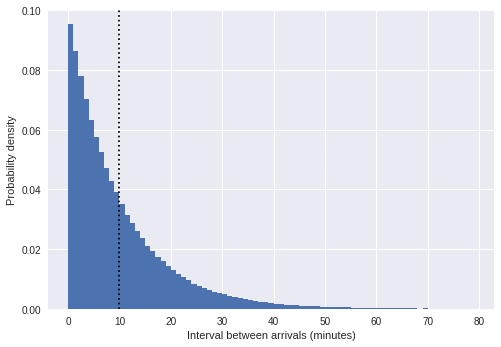

In [0]:
plt.style.use('seaborn')
plt.hist(intervals, bins=np.arange(80), density=True)
plt.axvline(intervals.mean(), color='black', linestyle='dotted')
plt.xlabel('Interval between arrivals (minutes)')
plt.ylabel('Probability density')

The vertical dotted line here shows the mean interval of about 10 minutes. This looks very much like an exponential distribution, and that is no accident: our simulation of bus arrival times as uniform random numbers very closely approximates a Poisson process, and for such a process it can be shown that the distribution of intervals between arrivals is exponential.

(Side note: In our case this is only approximately exponential; in reality the intervals T between N uniformly sampled points within a timespan Nτ follow the Beta distribution: T/(Nτ)∼Beta[1,N], which in the large N limit approaches T∼Exp[1/τ]. See, e.g. this StackExchange post, or this twitter thread for more details).

An exponential distribution of intervals implies that the arrival times follow a Poisson process. To double-check this reasoning, we can confirm that it matches another property of a Poisson process: the number of arrivals within a fixed span of time will be Poisson-distributed. Let's check this by binning our simulated arrivals into hourly blocks:

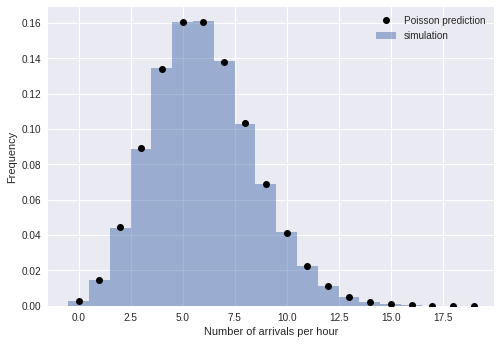

In [0]:
# count n of arrivals in 1-hour bins
binsize = 60
binned_arrivals = np.bincount((bus_arrival_times // binsize).astype(int))
x = np.arange(20)

# plot results
plt.hist(binned_arrivals, bins=x - 0.5, density=True, alpha=0.5, label='simulation')
plt.plot(x, poisson(binsize / tau).pmf(x), 'ok', label='Poisson prediction')
plt.xlabel('Number of arrivals per hour')
plt.ylabel('Frequency')
plt.legend()

The close match between the empirical and theoretical values gives confidence that our interpretation is correct: for large N, the arrival times we simulated above are well-described by a Poisson process, which implies exponentially-distributed arrival intervals.

That means we can write the probability distribution:
$$p(T)=1τe−T/τ$$
Plugging this into the above results, we find that the average waiting time experienced by a person is
$$E[W]=∫∞0T2 e−T/τ2∫∞0T e−T/τ=2τ32(τ2)=τ$$
For bus arrivals consistent with a Poisson process, the expected wait time for a passenger is identical to the average interval between arrivals.

A complementary way to reason about this is this: a Poisson process is a memoryless process, meaning that the history of events has no bearing on the expected time to the next event. So when you arrive at the bus stop, the average waiting time until the next bus is always the same: in our case, it is 10 minutes, and this is regardless of how long it has been since the previous bus! Along the same lines, it does not matter how long you have been waiting already: the expected time to the next arrival is always exactly 10 minutes: for a Poisson process, you get no "credit" for time spent waiting.



In [0]:
URL = 'https://gist.githubusercontent.com/jakevdp/82409002fcc5142a2add0168c274a869/raw/1bbabf78333306dbc45b9f33662500957b2b6dc3/arrival_times.csv'

In [0]:
from urllib.request import urlretrieve
urlretrieve(URL, 'arrival_times.csv')

('arrival_times.csv', <http.client.HTTPMessage at 0x7eff79027cc0>)

To determine whether the waiting time paradox describes reality, we can dig into some data, available for download here: [arrival_times.csv](https://gist.githubusercontent.com/jakevdp/82409002fcc5142a2add0168c274a869/raw/1bbabf78333306dbc45b9f33662500957b2b6dc3/arrival_times.csv) (3MB CSV file). The dataset contains scheduled and actual arrival times for Seattle's Rapid Ride lines C, D, and E at the 3rd & Pike bus stop in downtown Seattle, recorded during the second quarter of 2016 (huge thanks to Mark Hallenbeck of the Washington State Transportation Center for providing this data!).

In [0]:
df = pd.read_csv('arrival_times.csv')
df = df.dropna(axis=0, how='any')
df.head()

,OPD_DATE,VEHICLE_ID,RTE,DIR,TRIP_ID,STOP_ID,STOP_NAME,SCH_STOP_TM,ACT_STOP_TM
0,2016-03-26,6201,673,S,30908177,431,3RD AVE & PIKE ST (431),01:11:57,01:13:19
1,2016-03-26,6201,673,S,30908033,431,3RD AVE & PIKE ST (431),23:19:57,23:16:13
2,2016-03-26,6201,673,S,30908028,431,3RD AVE & PIKE ST (431),21:19:57,21:18:46
3,2016-03-26,6201,673,S,30908019,431,3RD AVE & PIKE ST (431),19:04:57,19:01:49
4,2016-03-26,6201,673,S,30908252,431,3RD AVE & PIKE ST (431),16:42:57,16:42:39


The reason I sought data from Rapid Ride routes in particular is that for much of the day, the buses are scheduled at regular intervals of between 10 and 15 minutes — not to mention the fact that I'm a frequent passenger on the C-line.

In [0]:
df.shape

(38917, 9)

## Data Cleanup
To start with, let's do a little bit of data cleanup to get it into a form that's easier to work with:

In [0]:
# combine date and time into a single timestamp
df['scheduled'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['SCH_STOP_TM'])
df['actual'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['ACT_STOP_TM'])

# if scheduled & actual span midnight, then the actual day needs to be adjusted
minute = np.timedelta64(1, 'm')
hour = 60 * minute
diff_hrs = (df['actual'] - df['scheduled']) / hour
df.loc[diff_hrs > 20, 'actual'] -= 24 * hour
df.loc[diff_hrs < -20, 'actual'] += 24 * hour
df['minutes_late'] = (df['actual'] - df['scheduled']) / minute

# map internal route codes to external route letters
df['route'] = df['RTE'].replace({673: 'C', 674: 'D', 675: 'E'}).astype('category')
df['direction'] = df['DIR'].replace({'N': 'northbound', 'S': 'southbound'}).astype('category')

# extract useful columns
df = df[['route', 'direction', 'scheduled', 'actual', 'minutes_late']].copy()

df.head()

,route,direction,scheduled,actual,minutes_late
0,C,southbound,2016-03-26 01:11:57,2016-03-26 01:13:19,1.366667
1,C,southbound,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.733333
2,C,southbound,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.183333
3,C,southbound,2016-03-26 19:04:57,2016-03-26 19:01:49,-3.133333
4,C,southbound,2016-03-26 16:42:57,2016-03-26 16:42:39,-0.300000


## How Late Are Buses?
There are essentially six different datasets within this table: the northbound and southbound directions for each of the C, D, and E lines. To get a feeling for their characteristics, let's plot a histogram of the actual minus scheduled arrival times for each of these six:

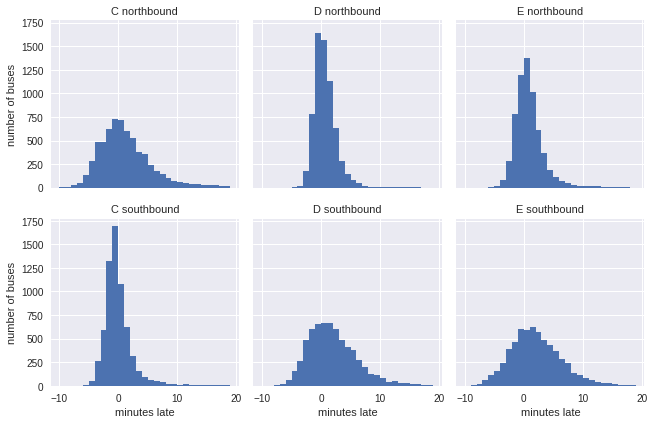

In [0]:
g = sns.FacetGrid(df, row='direction', col='route')
g.map(plt.hist, 'minutes_late', bins=np.arange(-10, 20))
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('minutes late', 'number of buses')

You might expect that the buses stick closer to their schedule near the beginning of each one-way trip and show more spread near the end, and this is borne out in the data: the southbound C-line and northbound D and E lines are near the beginning of their respective routes, and in the opposite direction they are near the end.

In [0]:
def compute_headway(scheduled):
  minute = np.timedelta64(1, 'm')
  return scheduled.sort_values().diff() / minute

grouped = df.groupby(['route', 'direction'])
df['actual_interval'] = grouped['actual'].transform(compute_headway)
df['scheduled_interval'] = grouped['scheduled'].transform(compute_headway)

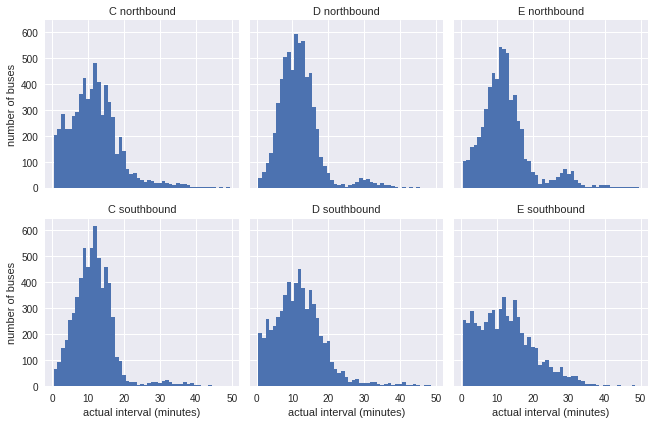

In [0]:
g = sns.FacetGrid(df.dropna(), row='direction', col='route')
g.map(plt.hist, 'actual_interval', bins=np.arange(50) + 0.5)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('actual interval (minutes)', 'number of buses')

It's already clear that these don't look much like the exponential distribution of our model, but that is not telling us much yet: the distributions may be affected by non-constant scheduled arrival intervals.

Let's repeat the above chart, examining the scheduled rather than observed arrival intervals:

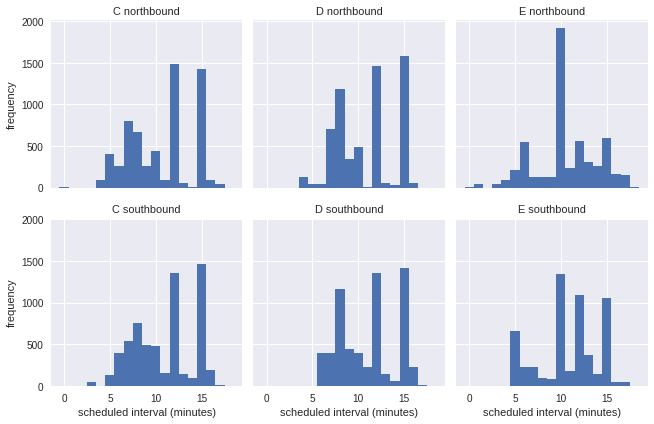

In [0]:
g = sns.FacetGrid(df.dropna(), row='direction', col='route')
g.map(plt.hist, 'scheduled_interval', bins=np.arange(20) - 0.5)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('scheduled interval (minutes)', 'frequency')

This shows that the buses come at variety of arrival intervals thorughout the week, so we cannot evaluate the accuracy of the waiting time paradox from the distributions of raw arrival times.

## Constructing Uniform Schedules
Even though the scheduled arrival intervals are not uniform, there are a few particular intervals that have a large number of arrivals: for example, there are nearly 2000 northbound E-line buses with a scheduled interval of 10 minutes. In order to explore whether the waiting time paradox applies, let's group the data by line, direction, and scheduled interval, then re-stack these similar arrivals together as if they had happened in sequence. This should maintain all the relevant characteristics of the raw data, while making it easier to directly compare with the predictions of the waiting time paradox.

In [0]:
def stack_sequence(data):
  # first sort by scheduled time
  data = data.sort_values('scheduled')

  # re-stack data & recompute relevant quantities
  data['scheduled'] = data['scheduled_interval'].cumsum()
  data['actual'] = data['scheduled'] + data['minutes_late']
  data['actual_interval'] = data['actual'].sort_values().diff()
  return data

subset = df[df.scheduled_interval.isin([10, 12, 15])]
grouped = subset.groupby(['route', 'direction', 'scheduled_interval'])
sequenced = grouped.apply(stack_sequence).reset_index(drop=True)

sequenced.head()

,route,direction,scheduled,actual,minutes_late,actual_interval,scheduled_interval
0,C,northbound,10.0,12.400000,2.400000,NaN,10.0
1,C,northbound,20.0,27.150000,7.150000,0.183333,10.0
2,C,northbound,30.0,26.966667,-3.033333,14.566667,10.0
3,C,northbound,40.0,35.516667,-4.483333,8.366667,10.0
4,C,northbound,50.0,53.583333,3.583333,18.066667,10.0


Using this cleaned data, we can plot the distribution of "actual" arrival intervals for each route, direction, and arrival frequency:

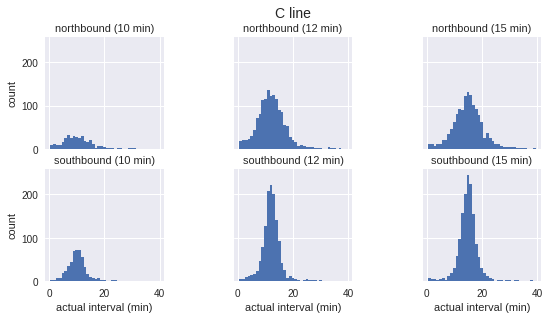

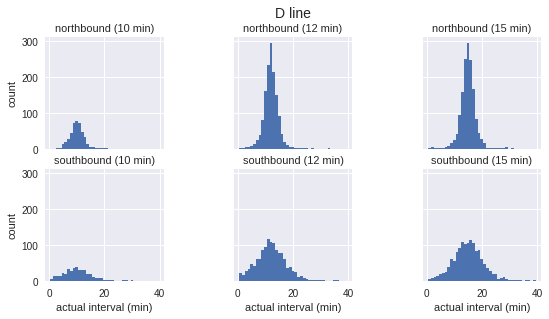

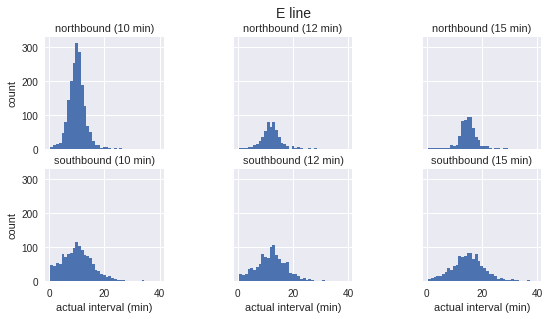

In [0]:
for route in ['C', 'D', 'E']:
    g = sns.FacetGrid(sequenced.query(f"route == '{route}'"),
                      row="direction", col="scheduled_interval")
    g.map(plt.hist, "actual_interval", bins=np.arange(40) + 0.5)
    g.set_titles('{row_name} ({col_name:.0f} min)')
    g.set_axis_labels('actual interval (min)', 'count')
    g.fig.set_size_inches(8, 4)
    g.fig.suptitle(f'{route} line', y=1.05, fontsize=14)

We see that for each line and schedule, the distribution of observed arrival intervals is nearly Gaussian, is peaked near the scheduled arrival interval, and has a standard deviation that is smaller near the beginning of the route (southbound for C, northbound for D/E) and larger near the end. Even without a statistical test, it's clear by eye that the actual arrival intervals are definitely not exponentially distributed, which is the basic assumption on which the waiting time paradox rests.

We can make use of the wait time simulation function we used above in order to find the average wait time for each bus line, direction, and schedule:



In [0]:
grouped = sequenced.groupby(['route', 'direction', 'scheduled_interval'])
sims = grouped['actual'].apply(simulate_wait_times)
sims.apply(lambda times: '{0:.1f} +/- {1:.1f}'.format(times.mean(), times.std()))

route  direction   scheduled_interval
C      northbound  10.0                  7.8 +/- 12.5
                   12.0                   7.4 +/- 5.7
                   15.0                   8.8 +/- 6.4
       southbound  10.0                   6.2 +/- 6.3
                   12.0                   6.8 +/- 5.2
                   15.0                   8.4 +/- 7.3
D      northbound  10.0                   6.1 +/- 7.1
                   12.0                   6.5 +/- 4.6
                   15.0                   7.9 +/- 5.3
       southbound  10.0                   6.7 +/- 5.3
                   12.0                   7.5 +/- 5.9
                   15.0                   8.8 +/- 6.5
E      northbound  10.0                   5.5 +/- 3.7
                   12.0                   6.5 +/- 4.3
                   15.0                   7.9 +/- 4.9
       southbound  10.0                   6.8 +/- 5.6
                   12.0                   7.3 +/- 5.2
                   15.0                   8.

The average waiting times are are perhaps a minute or two longer than half the scheduled interval, but not equal to the scheduled interval as the waiting time paradox implied. In other words, the inspection paradox is confirmed, but the waiting time paradox does not appear to match reality.

## Conclusion
The waiting time paradox has been an interesting launching-point for a discussion that covered simulation, probability, and comparison of statistical assumptions with reality. Although we confirmed that real-world bus lines do follow some version of the inspection paradox, the above analysis shows pretty definitively that the core assumption behind the waiting time paradox — that the arrival of buses follows the statistics of a Poisson process — is not well-founded.

In retrospect, this is perhaps not all that surprising: a Poisson process is a memoryless process that assumes the probability of an arrival is entirely independent of the time since the previous arrival. In reality, a well-run bus system will have schedules deliberately structured to avoid this kind of behavior: buses don't begin their routes at random times throughout the day, but rather begin their routes on a schedule chosen to best serve the transit-riding public.

The larger lesson here is that you should be careful about the assumptions you bring to any data analysis task. A Poisson process is a good description for arrival time data — sometimes. But just because one type of data sounds like another type of data, it does not mean that assumptions valid for one are necessarily valid for the other. Often assumptions that seem correct on their face can lead to conclusions that don't match reality.